Installing Polygon API

In [1]:
!pip install polygon-api-client


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Pulling Sector ETF Data

In [2]:
from polygon import RESTClient
import pandas as pd
import time

# Your API Key
api_key = "QsO_c5YIOMokbiL6pSl2DTQV0CxLusBS"
client = RESTClient(api_key)

# Function to get daily close prices
def get_sector_prices(ticker, start_date, end_date):
    bars = []
    for bar in client.list_aggs(
        ticker=ticker,
        multiplier=1,
        timespan="day",
        from_=start_date,
        to=end_date,
        limit=50000,
    ):
        bars.append(bar)
    
    df = pd.DataFrame([{
        'date': pd.to_datetime(bar.timestamp, unit='ms').date(),
        'close': bar.close
    } for bar in bars])
    
    df.set_index('date', inplace=True)
    df.rename(columns={'close': ticker}, inplace=True)
    return df

# Pulling a few tickers first to stay within limits
tickers = ['XLK', 'XLF', 'XLE']  # Start small — more later
start = "2015-01-01"
end = "2024-12-31"

all_data = pd.DataFrame()

for ticker in tickers:
    try:
        df = get_sector_prices(ticker, start, end)
        if all_data.empty:
            all_data = df
        else:
            all_data = all_data.join(df, how='outer')
        print(f"Downloaded: {ticker}")
        time.sleep(2.5)  # rate limit buffer
    except Exception as e:
        print(f"Failed for {ticker}: {e}")

# Check result
all_data.tail()



Downloaded: XLK
Downloaded: XLF
Downloaded: XLE


,XLK,XLF,XLE
date,,,
2024-12-24,240.53,48.99,84.64
2024-12-26,240.69,49.11,84.57
2024-12-27,237.49,48.75,84.56
2024-12-30,234.47,48.28,84.55
2024-12-31,232.52,48.33,85.66


In [3]:
!pip install fredapi



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Step 1: Load and Process Macro Data

In [4]:
from fredapi import Fred
import pandas as pd

# Connect to FRED
fred = Fred(api_key='46cbb3d72d7a6d27cb64ec89c75a161c')

# Pull monthly data with updated frequency alias
cpi = fred.get_series('CPIAUCSL').resample('ME').last()
fedfunds = fred.get_series('FEDFUNDS').resample('ME').last()


# Calculate YoY Inflation
cpi_yoy = cpi.pct_change(12) * 100



 Build the Macro Regime DataFrame

In [5]:
macro = pd.DataFrame({
    'cpi_yoy': cpi_yoy,
    'fedfunds': fedfunds
})

# Detect Fed Funds Rate trend using 6-month slope
macro['fedfunds_slope'] = macro['fedfunds'].diff(6)

# Classify slope as "up", "down", or "flat"
def classify_trend(x, threshold=0.1):
    if x > threshold:
        return 'up'
    elif x < -threshold:
        return 'down'
    else:
        return 'flat'

macro['rate_trend'] = macro['fedfunds_slope'].apply(classify_trend)


 Define Macro Regimes Based on Conditions

In [6]:
def tag_regime(row):
    if row['cpi_yoy'] > 3 and row['rate_trend'] == 'up':
        return 'Stagflation'
    elif row['cpi_yoy'] < 2 and row['rate_trend'] == 'down':
        return 'Recovery'
    elif row['rate_trend'] == 'up':
        return 'Hiking'
    elif row['rate_trend'] == 'down':
        return 'Easing'
    else:
        return 'Neutral'

macro['regime'] = macro.apply(tag_regime, axis=1)


Preview the Regime-Tagged Macro Data

In [7]:
macro[['cpi_yoy', 'fedfunds', 'rate_trend', 'regime']].tail(12)


,cpi_yoy,fedfunds,rate_trend,regime
2024-08-31,2.610914,5.33,flat,Neutral
2024-09-30,2.432541,5.13,down,Easing
2024-10-31,2.571403,4.83,down,Easing
2024-11-30,2.714168,4.64,down,Easing
2024-12-31,2.872366,4.48,down,Easing
2025-01-31,2.999413,4.33,down,Easing
2025-02-28,2.814270,4.33,down,Easing
2025-03-31,2.405585,4.33,down,Easing
2025-04-30,2.333747,4.33,down,Easing
2025-05-31,2.375934,4.33,down,Easing


In [8]:
# Resample ETF prices to month-end

# 🛠️ Fix: convert index to datetime
all_data.index = pd.to_datetime(all_data.index)

# ✅ Now resample to month-end frequency
sector_monthly = all_data.resample('ME').last()

sector_monthly = all_data.resample('ME').last()

# Calculate monthly returns
sector_returns = sector_monthly.pct_change()

# Merge with macro regimes
combined = pd.merge(sector_returns, macro[['regime']], left_index=True, right_index=True, how='inner')

# Preview
combined.tail()



,XLK,XLF,XLE,regime
2024-08-31,0.006993,0.045725,-0.020706,Neutral
2024-09-30,0.024645,-0.009182,-0.038124,Easing
2024-10-31,-0.015592,0.025596,0.008998,Easing
2024-11-30,0.051701,0.104561,0.078338,Easing
2024-12-31,-0.005177,-0.058629,-0.103318,Easing


Plot Average Sector Returns by Regime

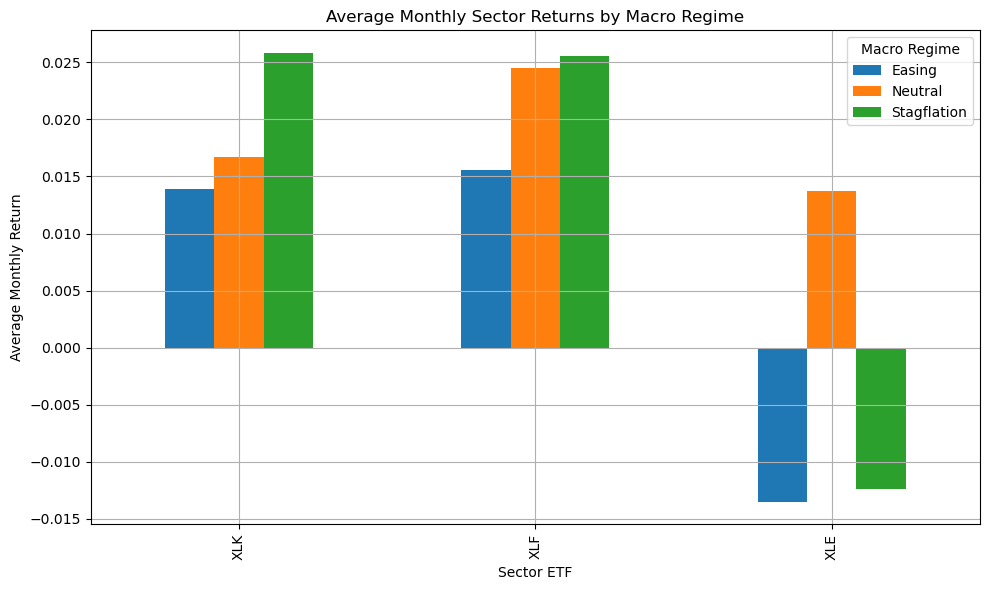

In [9]:
import matplotlib.pyplot as plt

# Step 1: Group and average returns by regime
avg_returns_by_regime = combined.groupby('regime').mean()

# Step 2: Transpose so sectors are rows
avg_returns_by_regime = avg_returns_by_regime.T

# Step 3: Plot
avg_returns_by_regime.plot(kind='bar', figsize=(10, 6))

# Step 4: Customize
plt.title('Average Monthly Sector Returns by Macro Regime')
plt.ylabel('Average Monthly Return')
plt.xlabel('Sector ETF')
plt.grid(True)
plt.legend(title='Macro Regime')
plt.tight_layout()

# Step 5: Show the chart
plt.show()


Installing Streamlit

In [10]:
pip install streamlit


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Running Dashboard

2025-08-05 22:55:32.485 
  command:

    streamlit run C:\Users\micha\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-08-05 22:55:32.489 Session state does not function when running a script without `streamlit run`


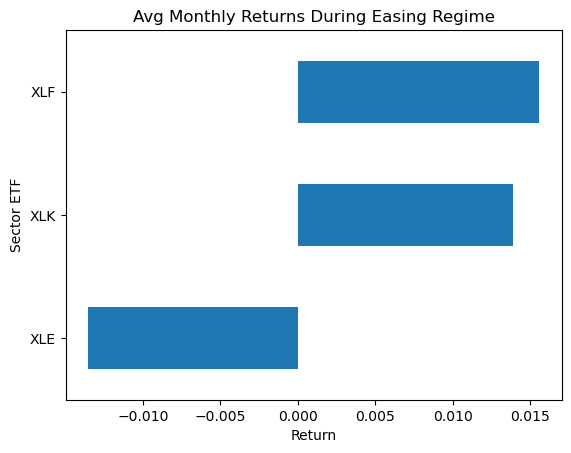

In [11]:
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt

# Load your combined dataset
# (Replace this with your real data loading step)
# You can use: combined = pd.read_csv('your_file.csv', index_col=0, parse_dates=True)
from pathlib import Path
if Path("combined.parquet").exists():
    combined = pd.read_parquet("combined.parquet")
else:
    st.error("Missing combined.parquet file — please export your DataFrame as Parquet.")
    st.stop()

st.title("Sector Allocation by Macro Regime")

# Sidebar: regime selector
regimes = combined['regime'].dropna().unique().tolist()
selected_regime = st.sidebar.selectbox("Select Macro Regime", sorted(regimes))

# Filter data
filtered = combined[combined['regime'] == selected_regime]

# Drop non-sector columns
sector_cols = [col for col in filtered.columns if col not in ['regime']]
avg_returns = filtered[sector_cols].mean()

# Plotting
fig, ax = plt.subplots()
avg_returns.sort_values().plot(kind='barh', ax=ax)
ax.set_title(f"Avg Monthly Returns During {selected_regime} Regime")
ax.set_xlabel("Return")
ax.set_ylabel("Sector ETF")
st.pyplot(fig)

# Optional: data preview
if st.checkbox("Show raw data"):
    st.write(filtered)


In [12]:
import os
os.getcwd()


'C:\\Users\\micha\\Downloads\\Research'